# Etapa 1: Carregamento da Base

Primeiro, carregamos as bibliotecas necessárias, além de carregar os dados dos arquivos `FakeRecogna.xlsx` e `FakeRecogna_no_removal_words.xlsx`. Em seguida, fazemos uma limpeza inicial, removendo valores ausentes na coluna `Classe` e concatenando as colunas de `Titulo`, `Subtitulo` e `Noticia` para formar uma nova coluna chamada `Texto_Completo`.


In [15]:
import pandas as pd
df = pd.read_excel('Dataset/FakeRecogna.xlsx')
df_no_removal = pd.read_excel('Dataset/FakeRecogna_no_removal_words.xlsx')
print(f'Antes da limpeza, existem {df["Classe"].isnull().sum()} NaNs na coluna Classe.')
df = df.dropna(subset=['Classe'])
print(f'Depois da limpeza, existem {df["Classe"].isnull().sum()} NaNs na coluna Classe.')
df_no_removal = df_no_removal.dropna(subset=['Classe'])
df['Texto_Completo'] = df['Titulo'].fillna('') + ' ' + df['Subtitulo'].fillna('') + ' ' + df['Noticia'].fillna('')
df_no_removal['Texto_Completo'] = df_no_removal['Titulo'].fillna('') + ' ' + df_no_removal['Subtitulo'].fillna('') + ' ' + df_no_removal['Noticia'].fillna('')


Antes da limpeza, existem 1 NaNs na coluna Classe.
Depois da limpeza, existem 0 NaNs na coluna Classe.


# Etapa 2: Limpeza e Pré-processamento

Nesta etapa, aplicamos várias técnicas de limpeza no texto:

1. **Remoção de URLs**: URLs presentes no texto são removidas.
2. **Remoção de Números**: Números também são excluídos.
3. **Remoção de Pontuação**: Pontuação é eliminada.
4. **Transformação para minúsculas**: O texto é convertido para minúsculas para uniformizar as palavras.
5. **Remoção de Stopwords**: Stopwords em português são removidas.
6. **Lemmatização**: As palavras são reduzidas à sua forma base utilizando o lemmatizer.

Esses passos são realizados por meio da função `preprocess_text`.


In [16]:
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
nltk.download('stopwords')
nltk.download('rslp')
def preprocess_text(texto):
    texto = re.sub(r'http\S+', '', texto)
    texto = re.sub(r'\d+', '', texto)
    texto = texto.translate(str.maketrans('', '', string.punctuation))
    texto = texto.lower()
    lista_stopwords = set(stopwords.words('portuguese'))
    texto = ' '.join([palavra for palavra in texto.split() if palavra not in lista_stopwords])
    stemmer = RSLPStemmer()
    texto = ' '.join([stemmer.stem(palavra) for palavra in texto.split()])
    return texto
df['Texto_Completo'] = df['Texto_Completo'].apply(preprocess_text)
df_no_removal['Texto_Completo'] = df_no_removal['Texto_Completo'].apply(preprocess_text)


[nltk_data] Downloading package stopwords to C:\Users\Antonio
[nltk_data]     Aleixo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to C:\Users\Antonio
[nltk_data]     Aleixo\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


# Etapa 3: Separar os Dados em Treino e Teste

Na etapa seguinte, vamos dividir os dados em dois conjuntos:

- **Treinamento**: 80% dos dados.
- **Teste**: 20% dos dados.

Usamos a função `train_test_split` do `sklearn` para realizar essa divisão, garantindo que a distribuição das classes (verdadeiro e falso) seja mantida em ambos os conjuntos.


In [17]:
from sklearn.model_selection import train_test_split
X = df['Texto_Completo']
y = df['Classe']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train_sem_remocao, X_test_sem_remocao, y_train_no_removal, y_test_no_removal = train_test_split(df_no_removal['Texto_Completo'], df_no_removal['Classe'], test_size=0.2, random_state=42, stratify=df_no_removal['Classe'])


# Etapa 4: Tratamento de Desbalanceamento de Classes

Em alguns casos, as classes podem ser desbalanceadas, ou seja, uma classe pode ter muito mais exemplos do que a outra. Para tratar isso, utilizamos a técnica de **oversampling** para aumentar o número de exemplos da classe minoritária, tornando o modelo mais equilibrado.


In [18]:
from sklearn.utils import resample
df_train = pd.concat([X_train, y_train], axis=1)
df_maioria = df_train[df_train['Classe'] == 0]
df_minoria = df_train[df_train['Classe'] == 1]
df_minoria_amostrada = resample(df_minoria, replace=True, n_samples=len(df_maioria), random_state=42)
df_train_balanced = pd.concat([df_maioria, df_minoria_amostrada])
X_train_balanceado = df_train_balanced['Texto_Completo']
y_train_balanceado = df_train_balanced['Classe']


# Etapa 5: Extração de Características usando TF-IDF

Nesta etapa, utilizamos a técnica **TF-IDF** para converter os textos em vetores numéricos que possam ser usados pelos modelos de machine learning. O TF-IDF é uma forma de medir a importância de uma palavra em um documento em relação ao resto do corpus.


In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
vetor = TfidfVectorizer(max_features=5000)
X_train_tfidf = vetor.fit_transform(X_train_balanced)
X_test_tfidf = vetor.transform(X_test)
X_train_sem_remocao_tfidf = vetor.fit_transform(X_train_sem_remocao)
X_test_sem_remocao_tfidf = vetor.transform(X_test_sem_remocao)


# Etapa 6: Treinamento dos Modelos

Nesta etapa, vamos treinar dois modelos de machine learning: **Regressão Logística** e **Random Forest**. Ambos são algoritmos populares para tarefas de classificação binária.


In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
modelo_log = LogisticRegression()
modelo_log.fit(X_train_tfidf, y_train_balanceado)
y_pred_log = modelo_log.predict(X_test_tfidf)
modelo_rf = RandomForestClassifier()
modelo_rf.fit(X_train_tfidf, y_train_balanceado)
y_pred_rf = modelo_rf.predict(X_test_tfidf)


# Etapa 7: Validação Cruzada

Nesta etapa, vamos realizar a validação cruzada (cross-validation) para os modelos de **Regressão Logística** e **Random Forest**. A validação cruzada nos ajuda a avaliar o desempenho dos modelos em diferentes subconjuntos dos dados, garantindo uma avaliação mais robusta.

A acurácia será utilizada como métrica de avaliação.


In [22]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score
log_cv_scores = cross_val_score(modelo_log, X_train_tfidf, y_train_balanceado, cv=5, scoring=make_scorer(accuracy_score))
rf_cv_scores = cross_val_score(modelo_rf, X_train_tfidf, y_train_balanceado, cv=5, scoring=make_scorer(accuracy_score))
print(f'Validação Cruzada (Regressão logística): {log_cv_scores}')
print(f'Validação Cruzada (Random Forest): {rf_cv_scores}')


Validação Cruzada (Regressão logística): [0.96796218 0.95745798 0.96113445 0.96953782 0.96323529]
Validação Cruzada (Random Forest): [0.97846639 0.97531513 0.97426471 0.97741597 0.97846639]


# Etapa 8: Avaliar o Desempenho dos Modelos

Após o treinamento dos modelos, avaliaremos o desempenho de ambos os modelos de **Regressão Logística** e **Random Forest** no conjunto de dados de teste. A acurácia será apresentada juntamente com o relatório de classificação para cada modelo.


In [23]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
print(f'Acurácia do modelo de Regressão Logística: {accuracy_score(y_test, y_pred_log)}')
print(f'Relatório de Classificação (Regressão logística):\n{classification_report(y_test, y_pred_log)}')
print(f'Acurácia do modelo de Random Forest: {accuracy_score(y_test, y_pred_rf)}')
print(f'Relatório de Classificação (Random Forest):\n{classification_report(y_test, y_pred_rf)}')


Acurácia do modelo de Regressão Logística: 0.9664006719865603
Relatório de Classificação (Regressão logística):
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97      1191
         1.0       0.97      0.97      0.97      1190

    accuracy                           0.97      2381
   macro avg       0.97      0.97      0.97      2381
weighted avg       0.97      0.97      0.97      2381

Acurácia do modelo de Random Forest: 0.9601007979840404
Relatório de Classificação (Random Forest):
              precision    recall  f1-score   support

         0.0       0.94      0.98      0.96      1191
         1.0       0.98      0.94      0.96      1190

    accuracy                           0.96      2381
   macro avg       0.96      0.96      0.96      2381
weighted avg       0.96      0.96      0.96      2381



# Etapa 9: Visualizar a Matriz de Confusão para os Modelos

A matriz de confusão ajuda a visualizar o desempenho do modelo, mostrando os acertos e erros nas classificações para as classes "Verdadeira" e "Falsa".
Vamos exibir a matriz de confusão para ambos os modelos de **Regressão Logística** e **Random Forest**.


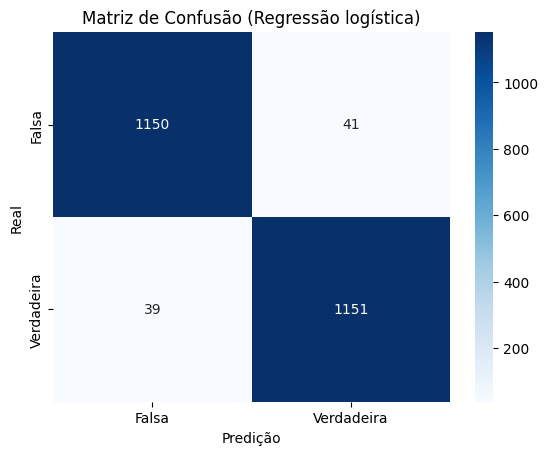

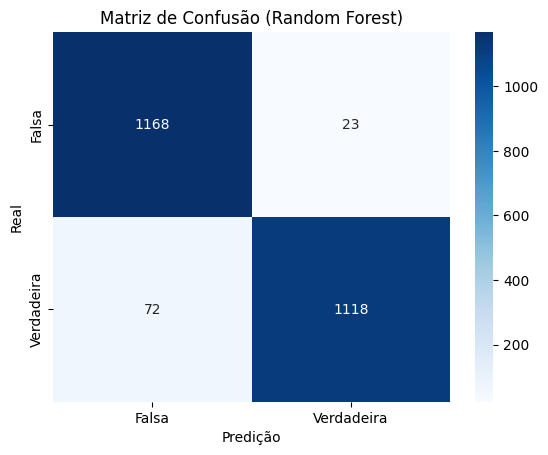

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
matriz_logistica = confusion_matrix(y_test, y_pred_log)
matriz_randomica = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(matriz_logistica, annot=True, fmt='d', cmap='Blues', xticklabels=['Falsa', 'Verdadeira'], yticklabels=['Falsa', 'Verdadeira'])
plt.xlabel('Predição')
plt.ylabel('Real')
plt.title('Matriz de Confusão (Regressão logística)')
plt.show()
sns.heatmap(matriz_randomica, annot=True, fmt='d', cmap='Blues', xticklabels=['Falsa', 'Verdadeira'], yticklabels=['Falsa', 'Verdadeira'])
plt.xlabel('Predição')
plt.ylabel('Real')
plt.title('Matriz de Confusão (Random Forest)')
plt.show()


# Etapa 10: Análise das Palavras Mais Associadas a Fake News

Para entender melhor os dados, vamos identificar as palavras mais frequentemente associadas a **Fake News**. Isso pode nos ajudar a compreender melhor os padrões linguísticos que são característicos das notícias falsas.
Vamos exibir as 20 palavras mais associadas a **Fake News** e apresentar um gráfico de barras para visualização.



Palavras mais associadas a Fake News:
covid         4935
coronavíru    4230
cas           4138
brasil        3954
govern        3807
vacin         3762
saud          3534
presid        3481
bolsonar      3303
dia           3043
país          2912
pandem        2859
n             2730
ano           2474
pesso         2435
d             2248
mort          2243
feder         2239
hoj           2065
minist        2016
Name: count, dtype: int64


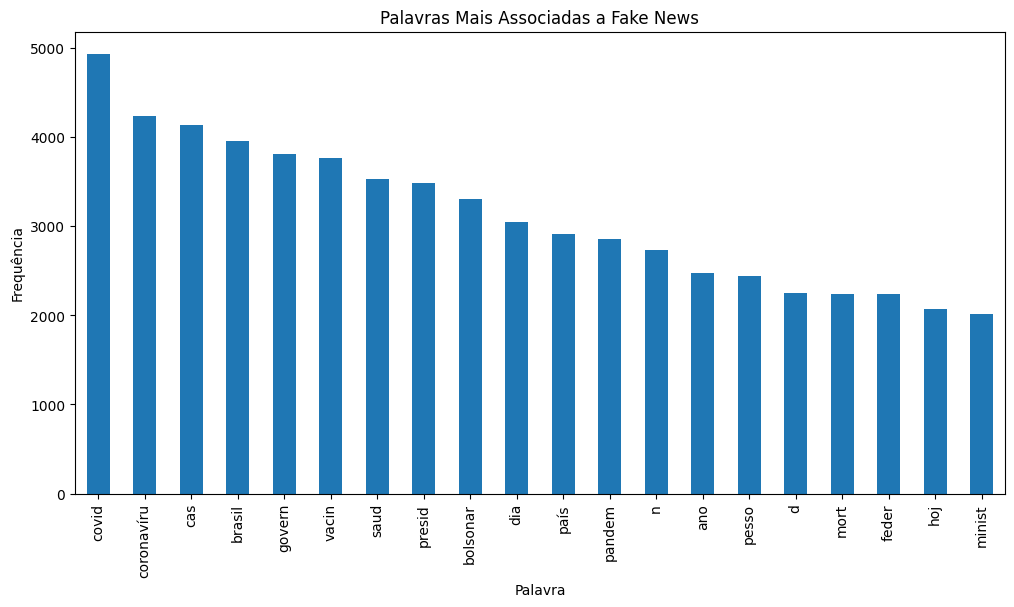

In [25]:

palavras_log = ' '.join(df[df['Classe'] == 1]['Texto_Completo']).split()
palavras_fake_news = pd.Series(palavras_log).value_counts().head(20)
print("\nPalavras mais associadas a Fake News:")
print(palavras_fake_news)
palavras_fake_news.plot(kind='bar', figsize=(12, 6))
plt.title('Palavras Mais Associadas a Fake News')
plt.xlabel('Palavra')
plt.ylabel('Frequência')
plt.show()
